<a href="https://colab.research.google.com/github/debjanim/streamflow-prediction/blob/main/streamflow_rfr_205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A Random Forest Regressor Model
##### The beginning of ML possibilities. 
### A sMAPE score of 0.4075870059426494


In [ ]:
# Import relevant libraries. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

In [ ]:
# Load Data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the relevant .csv file to local drive. 
!cp /content/drive/MyDrive/EDAs/HYSETS_important.csv /content/

In [ ]:
# Load the dataframe
df = pd.read_csv('HYSETS_important.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,0,6.4,-27.2,-38.9,NaN
1,1950-01-02,0,1.3,-27.8,-39.4,NaN
2,1950-01-03,0,0.0,-15.6,-41.1,NaN
3,1950-01-04,0,0.0,-15.0,-21.7,NaN
4,1950-01-05,0,0.0,-12.2,-26.1,NaN


In [ ]:
# Watershed's 175 and 8 have the fewest missing discharge values. 
# Now to explore another watershed. 
mean = df.watershed.unique()
missing = {}
for i in mean: 
  shed = df[(df.watershed == i)]
  nums = shed.discharge.isnull().sum()
  missing[nums] = i
# What is the third most populous discharge value'd watershed?
sorted(missing.items())[2] 

(1741, 205)

In [ ]:
# Isolating a single watershed, since all data that changes between watersheds has been removed. 
shed205 = df[(df.watershed == 205)]
# Switching the 'time' column to the datetime format.
shed205["time"] = pd.to_datetime(shed205["time"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


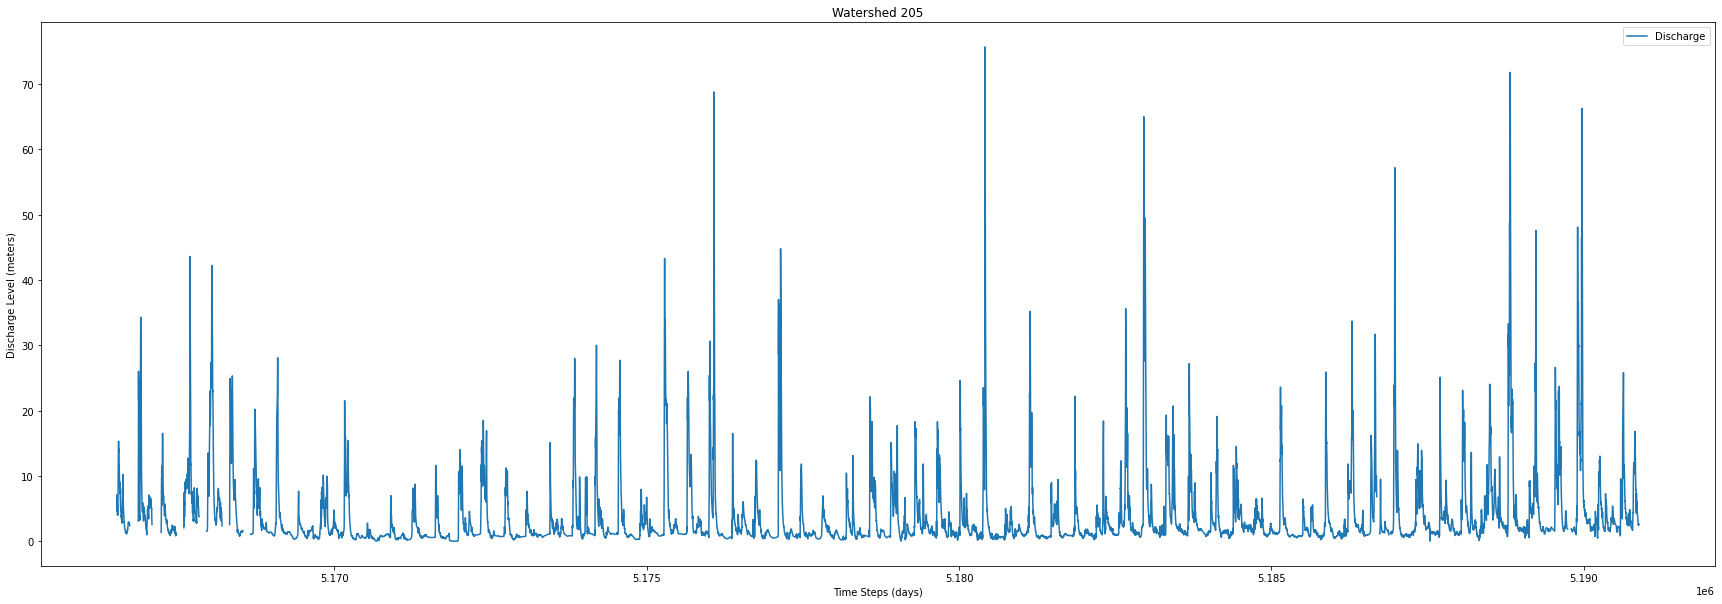

In [ ]:
# For visual representation, plotting discharge of watershed 205

x = range(len(shed205))
y1 = shed205.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 205")
plt.xlabel("Time Steps (days)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (meters)")
plt.plot(y1, label = 'Discharge')




plt.legend()
plt.show()

In [ ]:
# There appears to be a gulf of discharge values right at the end. (Perhaps this watershed's sensor turned off earlier.)
test = shed205.copy()
test.dropna()

,time,watershed,pr,tasmax,tasmin,discharge
5166522,1950-04-23,205,0.074635,5.912317,-2.073695,6.85
5166523,1950-04-24,205,0.000000,3.652505,-3.025574,6.12
5166524,1950-04-25,205,0.000000,2.082985,-4.673486,6.29
5166525,1950-04-26,205,0.000000,1.490501,-5.531106,6.40
5166526,1950-04-27,205,0.000000,5.080793,-6.700000,4.76
...,...,...,...,...,...,...
5190877,2016-12-27,205,1.170564,-10.097390,-22.942066,2.64
5190878,2016-12-28,205,0.929019,-3.541023,-14.312735,2.65
5190879,2016-12-29,205,0.000000,-6.199687,-16.686535,2.61
5190880,2016-12-30,205,0.926618,-10.480793,-16.324427,2.52


In [ ]:
# It appears watershed 8's discharge measurements ended 2016, instead of 2018 like watershed 175. 
shed205 = shed205[(shed205.time < '2017-01-01')]

In [ ]:
# Using Pandas built in function 'interpolate', nan values will be filled in. 
shed205.set_index('time', inplace = True)
for watershedID in set(shed205["watershed"]):
  shed205[shed205["watershed"] == watershedID] = shed205[shed205["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")

In [ ]:
# Observe how many nan's remain after interpolation. 
shed205.isnull().sum()

watershed    0
pr           0
tasmax       0
tasmin       0
discharge    0
dtype: int64

In [ ]:
# For experimentation, using a copy saves reloading time. 
model1 = shed205.copy()

In [ ]:
# Setting the index back to 1, 2, 3, ...
model1.reset_index(inplace=True) 
model1.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,205,0.819415,-19.975365,-29.133820,6.85
1,1950-01-02,205,0.000000,-24.203758,-27.345928,6.85
2,1950-01-03,205,0.000000,-29.017746,-36.503757,6.85
3,1950-01-04,205,0.000000,-26.956785,-40.761795,6.85
4,1950-01-05,205,0.000000,-30.449478,-39.001670,6.85


In [ ]:
# Herein we will create a function that creates represenations of the past days. 
# And A fortnight is the target variable. --> This can be changed to 10 days out, instead of 14. 

def advance(x):
  num_list = []
  length = len(model1.discharge)
  for i in range(length):
    if x + i >= length: # For calculating the target variable
      num = i
    elif i + x < 0: # For calculating the past. 
      num = i
    else:
      num = i + x # Other than the outliers, the value will be discharge[i + 'x']
    forecast = model1['discharge'][num]
    num_list.append(forecast)
  name = f"discharge_{x}"    
  model1[name] = num_list #model1['discharge'][num]


In [ ]:
# Yesterday's forecast. 
advance(-1)

In [ ]:
# Three days ago.
advance(-3)

In [ ]:
# Five days ago.
advance(-5)

In [ ]:
# One week ago.
advance(-7)

In [ ]:
# The target variable, two weeks out.
advance(14)

In [ ]:
model1.tail(20)

,time,watershed,pr,tasmax,tasmin,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
24452,2016-12-12,205,0.000000,-18.164406,-27.025156,3.82,3.94,4.18,4.40,4.76,2.48
24453,2016-12-13,205,0.000000,-16.172234,-24.161900,3.71,3.82,4.06,4.31,4.31,2.64
24454,2016-12-14,205,0.000000,-20.890396,-26.313570,3.60,3.71,3.94,4.18,4.40,2.65
24455,2016-12-15,205,0.000000,-15.734134,-26.880585,3.50,3.60,3.82,4.06,4.31,2.61
24456,2016-12-16,205,0.000000,-22.829750,-28.378078,3.39,3.50,3.71,3.94,4.18,2.52
24457,2016-12-17,205,0.000000,-24.311274,-32.428288,3.29,3.39,3.60,3.82,4.06,2.57
24458,2016-12-18,205,1.188727,-11.516911,-32.155636,3.20,3.29,3.50,3.71,3.94,3.20
24459,2016-12-19,205,1.088935,-1.979227,-13.009812,3.10,3.20,3.39,3.60,3.82,3.10
24460,2016-12-20,205,0.073486,-0.972338,-14.880480,3.01,3.10,3.29,3.50,3.71,3.01
24461,2016-12-21,205,0.000000,-0.989353,-17.502089,2.92,3.01,3.20,3.39,3.60,2.92


In [ ]:
# We will only be using discharge values. --> Pr values, at the minimum, also need to be considered.
model1.drop(['watershed', 'pr', 'tasmax', 'tasmin'], axis=1, inplace=True)

model1.head(3)

,time,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
0,1950-01-01,6.85,6.85,6.85,6.85,6.85,6.85
1,1950-01-02,6.85,6.85,6.85,6.85,6.85,6.85
2,1950-01-03,6.85,6.85,6.85,6.85,6.85,6.85


In [ ]:
# We will be focusing on the last twenty years of data.
df = model1[(model1.time >= '1997-01-01')] 

df.head(3)

,time,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
17167,1997-01-01,1.32,1.48,1.66,1.28,1.44,1.32
17168,1997-01-02,1.39,1.32,1.29,1.52,1.38,1.16
17169,1997-01-03,1.46,1.39,1.48,1.66,1.28,1.12


In [ ]:
# The test data will be five years of data (2012 - 2017). 

df_train = df[(df.time < '2012-01-01')]
df_test = df[(df.time >= '2012-01-01')]
print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.2501026694045175


In [ ]:
# The 'time' column won't be needed for the RFR model. 
df_train.drop(['time'], axis=1, inplace=True)
df_test.drop(['time'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.drop(['time'], axis=1, inplace=True)

### Phase 2) Building the machine learning model.

##### We will be using a random forest regressor for the baseline. 

In [ ]:
# Import relevant libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
predict_train = df_train.drop('discharge_14', axis=1)
target_train = df_train['discharge_14']
predict_test = df_test.drop('discharge_14', axis=1)
target_test = df_test['discharge_14']
#x_train, x_test, y_train, y_test = train_test_split(predict, target, test_size=0.2, random_state=42)

In [ ]:
clf = RandomForestRegressor(n_estimators=800) # --> 800 is chosen at random. A Grid Search CV should be done to find best hyperparameters. 
clf.fit(predict_train, target_train)


RandomForestRegressor(n_estimators=800)

In [ ]:
# Testing the model's predictive capabilities. 
clf.score(predict_test,target_test)

0.272040202845357

In [ ]:
# Now to take that wonderfully accurate model and use it to predict the errors of our dataframe. 
aim = predict_test
prediction = clf.predict(aim)
print(prediction)

[0.941675  0.8235739 2.5969875 ... 2.3411875 2.687475  2.5546   ]


In [ ]:
bullseye = target_test
bullseye.reset_index(drop=True, inplace=True)

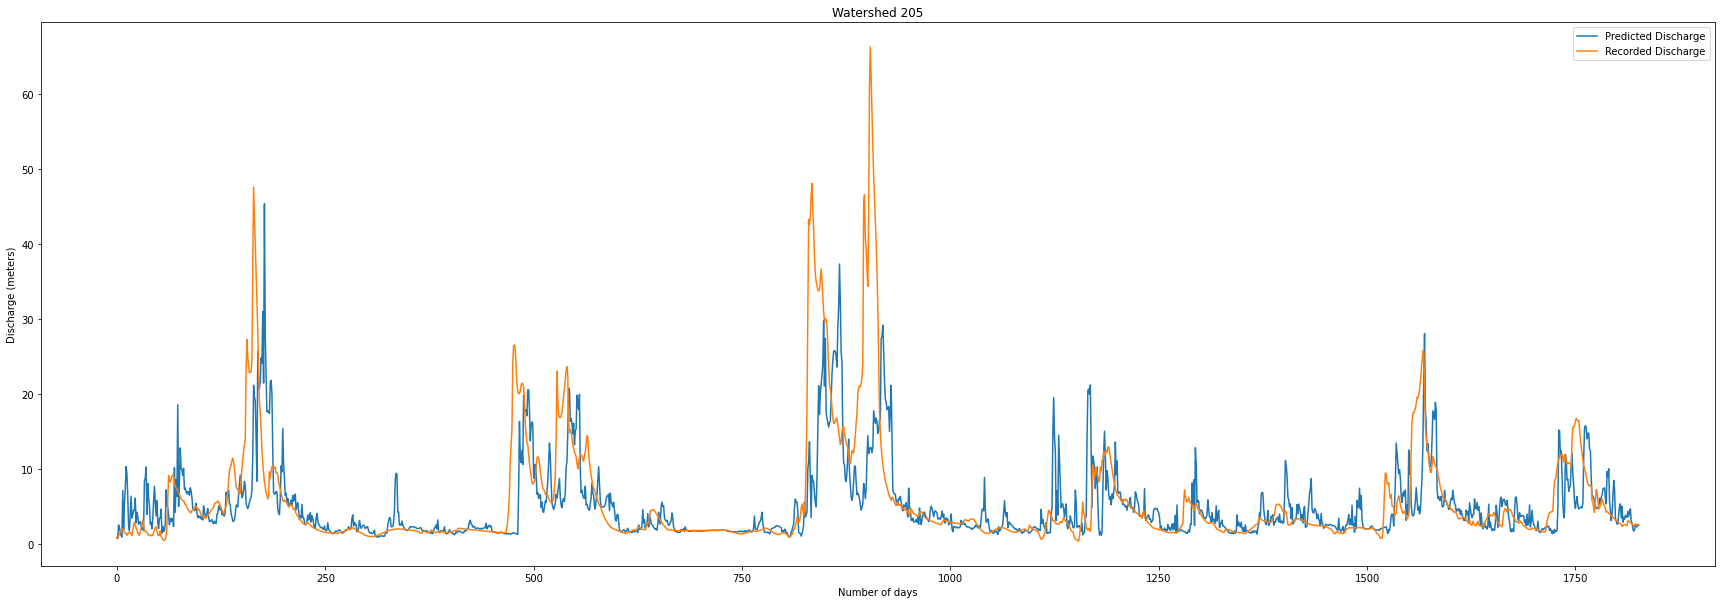

In [ ]:
# Plot the errors and water levels next to each oter to observe potential patterns. 
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 205")
plt.xlabel("Number of days") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge (meters)")
y = prediction
y2 = bullseye
plt.plot(y, label="Predicted Discharge")
plt.plot(y2, label="Recorded Discharge")
plt.legend()
plt.show()

In [ ]:
#SMAPE scoring for five years. 

n = len(prediction) # (1827)
total = 0
for i in range(len(prediction)):
  top = (prediction[i] - bullseye[i])
  bottom = ((prediction[i] + bullseye[i]) /2)
  answer = top/bottom
  if answer < 0:
    answer = answer * -1
  total += answer
SMAPE = total/n
SMAPE


0.4050537161232583